In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/immunoquest1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/immunoquest1/sample_submisson.csv
/kaggle/input/immunoquest1/Dataset/Dataset/val/mono/lisc_mono_7.jpg
/kaggle/input/immunoquest1/Dataset/Dataset/val/mono/rabbin_wbc_mono_151.jpg
/kaggle/input/immunoquest1/Dataset/Dataset/val/mono/pbc_mono_68.jpg
/kaggle/input/immunoquest1/Dataset/Dataset/val/mono/pbc_mono_16.jpg
/kaggle/input/immunoquest1/Dataset/Dataset/val/mono/lisc_mono_51.jpg
/kaggle/input/immunoquest1/Dataset/Dataset/val/mono/pbc_mono_159.jpg
/kaggle/input/immunoquest1/Dataset/Dataset/val/mono/pbc_mono_122.jpg
/kaggle/input/immunoquest1/Dataset/Dataset/val/mono/pbc_mono_83.jpg
/kaggle/input/immunoquest1/Dataset/Dataset/val/mono/pbc_mono_163.jpg
/kaggle/input/immunoquest1/Dataset/Dataset/val/mono/rabbin_wbc_mono_228.jpg
/kaggle/input/immunoquest1/Dataset/Dataset/val/mono/rabbin_wbc_mono_197.jpg
/kaggle/input/immunoquest1/Dataset/Dataset/val/mono/pbc_mono_57.jpg
/kaggle/input/immunoquest1/Dataset/Dataset/val/mono/pbc_mono_491.jpg
/kaggle/input/immunoquest1/Dataset/Data

In [2]:
base_dir = '/kaggle/input/immunoquest1/Dataset/Dataset'


In [3]:
train_dir = os.path.join(base_dir,'train')

In [4]:
train_baso_dir = os.path.join(train_dir,'baso')

In [5]:
print(dirname)

/kaggle/input/immunoquest1/Dataset/Dataset/train/baso


In [6]:
print(len(os.listdir(train_baso_dir)))

812


In [7]:
import numpy as np 
import pandas as pd 
from copy import deepcopy
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import torch.optim as optim



In [8]:
label_index = {"baso": 0, "eosi": 1, "lymp": 2,"mono": 3,"neut": 4}
index_label = {0: "baso", 1: "eosi", 2: "lymp",3: "mono", 4: "neut"}
def create_df(base):    
    dd = {"images": [], "labels": []}    
    for i in os.listdir(base):        
        label = os.path.join(base, i)        
        for j in os.listdir(label):            
            img = os.path.join(label, j)           
            dd["images"].append(img)            
            dd["labels"].append(label_index[i])   
    return pd.DataFrame(dd)

In [9]:

train_df = create_df("/kaggle/input/immunoquest1/Dataset/Dataset/train")
val_df = create_df("/kaggle/input/immunoquest1/Dataset/Dataset/val")


train_df, testing = train_test_split(train_df, random_state=42, test_size=0.2)
val_df, test_df = train_test_split(testing, random_state=42, test_size=0.5)
class CloudDS(Dataset):    
    def __init__(self, data, transform):        
        self.data = data        
        self.transform = transform            
    def __len__(self):        
        return len(self.data)        
    def __getitem__(self, x):        
        img_path, label = self.data.iloc[x, 0], self.data.iloc[x, 1]        
        img = Image.open(img_path)       
        img = self.transform(img)                 
        return img, label
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),     
                                       transforms.RandomRotation(30),          
                                       transforms.RandomHorizontalFlip(),       
                                       transforms.RandomVerticalFlip(),       
                                       transforms.ColorJitter(brightness=0.2,
                                                              contrast=0.2,
                                                              saturation=0.2,
                                                              hue=0.2),   
                                       transforms.ToTensor(),                 
                                       transforms.Normalize(        
                                           mean=[0.485, 0.456, 0.406],            
                                           std=[0.229, 0.224, 0.225] )])
val_test_transforms = transforms.Compose([transforms.Resize(256),               
                                          transforms.CenterCrop(224),             
                                          transforms.ToTensor(),                  
                                          transforms.Normalize(       
                                              mean=[0.485, 0.456, 0.406],                       
                                              std=[0.229, 0.224, 0.225]    )])
train_dataset = CloudDS(train_df, transform=train_transforms)
val_dataset = CloudDS(val_df, transform=val_test_transforms)
test_dataset = CloudDS(test_df, transform=val_test_transforms)


In [10]:
train_df.head(5)

,images,labels
557,/kaggle/input/immunoquest1/Dataset/Dataset/tra...,3
1586,/kaggle/input/immunoquest1/Dataset/Dataset/tra...,2
602,/kaggle/input/immunoquest1/Dataset/Dataset/tra...,3
442,/kaggle/input/immunoquest1/Dataset/Dataset/tra...,3
1775,/kaggle/input/immunoquest1/Dataset/Dataset/tra...,4


In [11]:
import torch 
from torch.utils.data import Dataset,DataLoader
train_data = DataLoader(train_df)
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=False)

resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 5)  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = deepcopy(resnet).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s]


In [12]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(1,51):      
    model.train()         
    diff = 0   
    total = 0    
    acc = 0        
    for data, target in train_dl:        
        optimizer.zero_grad()                
        data, target = data.to(device), target.to(device)                    
        out = model(data)              
        loss = criterion(out, target)        
        diff += loss.item()        
        acc += (out.argmax(1) == target).sum().item()        
        total += out.size(0)                
        loss.backward()        
        optimizer.step()
        
    train_loss.append(diff / total)    
    train_acc.append(acc / total)            
        
    model.eval()          
    diff = 0    
    total = 0    
    acc = 0        
    with torch.no_grad():        
        for data, target in val_dl:            
            data, target = data.to(device), target.to(device)                            
            out = model(data)            
            loss = criterion(out, target)            
            diff += loss.item()            
            acc += (out.argmax(1) == target).sum().item()            
            total += out.size(0)                
    val_loss.append(diff / total)    
    val_acc.append(acc / total)         
    if val_acc[-1] > best_acc:        
        best_acc = val_acc[-1]        
        best_model = deepcopy(model)                
    print(f"Epoch {epoch}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

Epoch 1, Train Loss: 0.0305, Train Acc: 0.6109, Val Loss: 0.0106, Val Acc: 0.8869
Epoch 2, Train Loss: 0.0148, Train Acc: 0.8227, Val Loss: 0.0183, Val Acc: 0.7965
Epoch 3, Train Loss: 0.0109, Train Acc: 0.8820, Val Loss: 0.0070, Val Acc: 0.9246
Epoch 4, Train Loss: 0.0098, Train Acc: 0.8933, Val Loss: 0.0161, Val Acc: 0.8668
Epoch 5, Train Loss: 0.0088, Train Acc: 0.8983, Val Loss: 0.0050, Val Acc: 0.9523
Epoch 6, Train Loss: 0.0077, Train Acc: 0.9056, Val Loss: 0.0089, Val Acc: 0.9095
Epoch 7, Train Loss: 0.0072, Train Acc: 0.9187, Val Loss: 0.0092, Val Acc: 0.9070
Epoch 8, Train Loss: 0.0069, Train Acc: 0.9212, Val Loss: 0.0112, Val Acc: 0.9070
Epoch 9, Train Loss: 0.0070, Train Acc: 0.9194, Val Loss: 0.0050, Val Acc: 0.9598
Epoch 10, Train Loss: 0.0056, Train Acc: 0.9354, Val Loss: 0.0062, Val Acc: 0.9497
Epoch 11, Train Loss: 0.0058, Train Acc: 0.9354, Val Loss: 0.0061, Val Acc: 0.9623
Epoch 12, Train Loss: 0.0056, Train Acc: 0.9303, Val Loss: 0.0034, Val Acc: 0.9724
Epoch 13, Tra

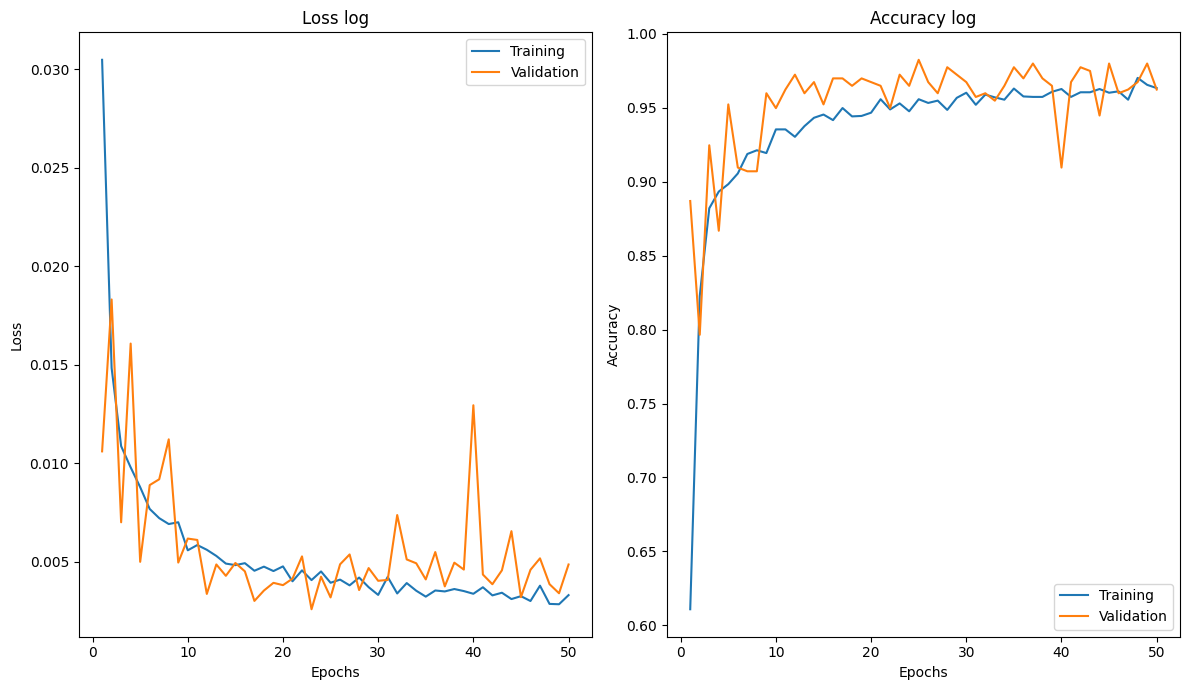

In [13]:
import matplotlib.pyplot as plt
EPOCHS = 50
epochs = list(range(1, EPOCHS + 1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
axes[0].plot(epochs, train_loss)
axes[0].plot(epochs, val_loss)
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Loss log")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[1].plot(epochs, train_acc)
axes[1].plot(epochs, val_acc)
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Accuracy log")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
plt.tight_layout()
plt.show()




In [14]:
# test_df = r'/kaggle/input/immunoquest1/Dataset/Dataset/test'


# def predict(x):    
#     img = Image.open(x).convert("RGB")    
#     img = val_test_transforms(img).unsqueeze(0)     
#     best_model.eval()    
#     with torch.no_grad():        
#         img = img.to(device)        
#         out = best_model(img)        
#     return out.argmax(1).item()
# pred = []
# truth = []
# for i in range(test_df.shape[0]):    
#     pred.append(predict(test_df.iloc[i, 0]))    
#     truth.append(test_df.iloc[i, 1]) 
# score = accuracy_score(truth, pred)
# report = classification_report(truth, pred, target_names=["baso", "eosi", "lymp","mono","neut"])
# cm = confusion_matrix(truth, pred)
# sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["baso", "eosi", "lymp","mono","neut"], yticklabels=["baso", "eosi", "lymp","mono","neut"])
# plt.title("Confusion Matrix - Accuracy: {}%".format(round(score * 100, 2)))
# plt.show()


In [15]:

torch.save(best_model.state_dict(),'/kaggle/working/model50.pth')

In [16]:
import os
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms

best_model.load_state_dict(torch.load('/kaggle/working/model50.pth'))
best_model.eval()  



<ipython-input-16-6e7c9d433c4b>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('/kaggle/working/model50.pth'))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:

transform = transforms.Compose([transforms.RandomResizedCrop(224),     
                                       transforms.RandomRotation(30),          
                                       transforms.RandomHorizontalFlip(),       
                                       transforms.RandomVerticalFlip(),       
                                       transforms.ColorJitter(brightness=0.2,
                                                              contrast=0.2,
                                                              saturation=0.2,
                                                              hue=0.2),   
                                       transforms.ToTensor(),                 
                                       transforms.Normalize(        
                                           mean=[0.485, 0.456, 0.406],            
                                           std=[0.229, 0.224, 0.225] )])

image_labels = []
test_folder = '/kaggle/input/immunoquest1/Dataset/Dataset/test'


In [18]:
for image_name in os.listdir(test_folder):   
    if image_name.endswith(('.jpg', '.png')):  # Only process image files        
        image_path = os.path.join(test_folder, image_name)                # Open the image        
        image = Image.open(image_path).convert("RGB") 
        image = transform(image) # Add batch dimension 
        image = image.unsqueeze(0)  # Add batch dimension (if missing)
        image = image.to(device)# Make the prediction        
        with torch.no_grad():            
            output = best_model(image)           
            _, predicted_class = torch.max(output, 1)  # Get the class index with the highest score                # Map class index to the label (assuming you have a list of class labels)        
            class_labels = ["0", "1", "2","3","4"]
            predicted_label = class_labels[predicted_class.item()]                # Append the image file name and predicted label to the list        
            image_labels.append([image_name, predicted_label])# Convert the list to a pandas DataFrame
            
df = pd.DataFrame(image_labels, columns=['Image_Name', 'Predicted_Label'])# Save the DataFrame to a CSV file
df.to_csv('predicted_labels1.csv', index=False)
print("CSV file with image names and predicted labels saved!")



CSV file with image names and predicted labels saved!
